In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import pylab
import wave
from pathlib import Path
import scipy.io.wavfile as wavfile
from scipy import signal
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [2]:
y_trn = pd.read_csv('train.csv')
y_trn['audio'] = '/Competition/train/train_new/train_' + y_trn['ID'].astype(str) + '.wav'
y_trn = y_trn[['audio', 'Label']]

In [3]:
y_trn.head(5)

,audio,Label
0,/Competition/train/train_new/train_0.wav,21
1,/Competition/train/train_new/train_1.wav,32
2,/Competition/train/train_new/train_2.wav,31
3,/Competition/train/train_new/train_3.wav,31
4,/Competition/train/train_new/train_4.wav,41


array([-0.22235107, -0.31622314, -0.3416748 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

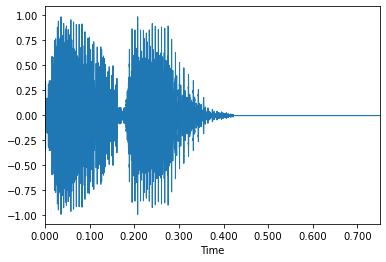

In [5]:
file_name='../Competition/train/train_new/train_0.wav'
audio_data, sampling_rate = librosa.load(file_name, sr=8000)
librosa.display.waveplot(audio_data, sr = sampling_rate)
Audio(file_name)
audio_data

In [4]:
y_trn['Label'].value_counts()

42    18000
41    18000
32    18000
31    18000
21    18000
Name: Label, dtype: int64

In [4]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, sr=8000)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=150)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(audio)), sr=sample_rate).T,axis=0)
    features = np.hstack([mfccs_scaled_features,chroma,mel])
    return features

extracted_features=[]
for(index_num, row) in tqdm(y_trn.iterrows()):
    file_name = os.path.join('..'+ str(row["audio"]))
    final_class_labels = row["Label"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])
    
    
extracted_features_df=pd.DataFrame(extracted_features, columns=['feature','label'])
extracted_features_df.head(10)

90000it [1:11:50, 20.88it/s]


,feature,label
0,"[-331.11435, 120.52334, -24.50714, 11.030669, ...",21
1,"[-280.03333, 133.98645, -30.156538, 36.52732, ...",32
2,"[-367.8451, 139.44296, -34.33354, 19.40069, 29...",31
3,"[-279.823, 131.39319, -23.451206, 36.959015, 2...",31
4,"[-338.3016, 142.60114, -14.976996, -5.7078714,...",41
5,"[-264.29874, 152.37752, -20.22218, 25.220469, ...",21
6,"[-399.96106, 100.93519, -24.40254, 11.085824, ...",21
7,"[-360.7496, 110.5621, -42.55951, 18.980934, 21...",31
8,"[-268.05936, 173.16457, -32.04659, 18.977383, ...",41
9,"[-341.38248, 99.93152, -31.17421, 30.12498, 23...",32


In [5]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['label'].tolist())

In [7]:
X.shape

(90000, 268)

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [11]:
model=Sequential()

model.add(Dense(100,input_shape=(268,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 1500
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='D:/anaconda3/5420 Assignments/Competition', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1500
2233/2250 [============================>.] - ETA: 0s - loss: 1.9774 - accuracy: 0.5119
Epoch 00001: val_loss improved from inf to 0.53527, saving model to D:/anaconda3/5420 Assignments\Competition
INFO:tensorflow:Assets written to: D:/anaconda3/5420 Assignments\Competition\assets
2250/2250 [==============================] - 10s 4ms/step - loss: 1.9682 - accuracy: 0.5131 - val_loss: 0.5353 - val_accuracy: 0.7978
Epoch 2/1500
2246/2250 [============================>.] - ETA: 0s - loss: 0.5776 - accuracy: 0.7496
Epoch 00002: val_loss improved from 0.53527 to 0.27476, saving model to D:/anaconda3/5420 Assignments\Competition
INFO:tensorflow:Assets written to: D:/anaconda3/5420 Assignments\Competition\assets
2250/2250 [==============================] - 13s 6ms/step - loss: 0.5774 - accuracy: 0.7498 - val_loss: 0.2748 - val_accuracy: 0.9113
Epoch 3/1500
2244/2250 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8189
Epoch 00003: val_loss improved from 0.27

Epoch 24/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9164
Epoch 00024: val_loss improved from 0.07374 to 0.07139, saving model to D:/anaconda3/5420 Assignments\Competition
INFO:tensorflow:Assets written to: D:/anaconda3/5420 Assignments\Competition\assets
2250/2250 [==============================] - 7s 3ms/step - loss: 0.2122 - accuracy: 0.9165 - val_loss: 0.0714 - val_accuracy: 0.9747
Epoch 25/1500
2242/2250 [============================>.] - ETA: 0s - loss: 0.2066 - accuracy: 0.9197
Epoch 00025: val_loss did not improve from 0.07139
2250/2250 [==============================] - 5s 2ms/step - loss: 0.2065 - accuracy: 0.9197 - val_loss: 0.0928 - val_accuracy: 0.9786
Epoch 26/1500
2231/2250 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9185
Epoch 00026: val_loss did not improve from 0.07139
2250/2250 [==============================] - 6s 2ms/step - loss: 0.2089 - accuracy: 0.9185 - val_loss: 0.0982 - val_accuracy: 0.970

2239/2250 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9267
Epoch 00051: val_loss did not improve from 0.05434
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1895 - accuracy: 0.9266 - val_loss: 0.0697 - val_accuracy: 0.9817
Epoch 52/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9261
Epoch 00052: val_loss did not improve from 0.05434
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1895 - accuracy: 0.9260 - val_loss: 0.0752 - val_accuracy: 0.9626
Epoch 53/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9216
Epoch 00053: val_loss did not improve from 0.05434
2250/2250 [==============================] - 7s 3ms/step - loss: 0.1964 - accuracy: 0.9217 - val_loss: 0.0612 - val_accuracy: 0.9844
Epoch 54/1500
2245/2250 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9239
Epoch 00054: val_loss did not improve from 0.05434
2250/22

Epoch 79/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9251
Epoch 00079: val_loss did not improve from 0.05211
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1956 - accuracy: 0.9252 - val_loss: 0.0560 - val_accuracy: 0.9826
Epoch 80/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9352
Epoch 00080: val_loss did not improve from 0.05211
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1781 - accuracy: 0.9352 - val_loss: 0.0689 - val_accuracy: 0.9826
Epoch 81/1500
2237/2250 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9223
Epoch 00081: val_loss did not improve from 0.05211
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1932 - accuracy: 0.9224 - val_loss: 0.0729 - val_accuracy: 0.9811
Epoch 82/1500
2233/2250 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9314
Epoch 00082: val_loss improved from 0.05211 

2229/2250 [============================>.] - ETA: 0s - loss: 0.1737 - accuracy: 0.9380
Epoch 00106: val_loss did not improve from 0.04672
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1733 - accuracy: 0.9382 - val_loss: 0.0518 - val_accuracy: 0.9853
Epoch 107/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1756 - accuracy: 0.9349
Epoch 00107: val_loss did not improve from 0.04672
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1757 - accuracy: 0.9349 - val_loss: 0.0700 - val_accuracy: 0.9809
Epoch 108/1500
2248/2250 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9386
Epoch 00108: val_loss did not improve from 0.04672
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1706 - accuracy: 0.9386 - val_loss: 0.0622 - val_accuracy: 0.9836
Epoch 109/1500
2242/2250 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9404
Epoch 00109: val_loss did not improve from 0.04672
2250

Epoch 133/1500
2237/2250 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9404
Epoch 00133: val_loss did not improve from 0.04188
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1622 - accuracy: 0.9403 - val_loss: 0.0438 - val_accuracy: 0.9873
Epoch 134/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1529 - accuracy: 0.9409
Epoch 00134: val_loss did not improve from 0.04188
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1530 - accuracy: 0.9409 - val_loss: 0.0428 - val_accuracy: 0.9879
Epoch 135/1500
2231/2250 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9427
Epoch 00135: val_loss did not improve from 0.04188
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1539 - accuracy: 0.9428 - val_loss: 0.0548 - val_accuracy: 0.9837
Epoch 136/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9419
Epoch 00136: val_loss did not improve fr

2239/2250 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9367
Epoch 00161: val_loss did not improve from 0.03931
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1523 - accuracy: 0.9368 - val_loss: 0.0435 - val_accuracy: 0.9851
Epoch 162/1500
2240/2250 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9398
Epoch 00162: val_loss did not improve from 0.03931
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1550 - accuracy: 0.9398 - val_loss: 0.0520 - val_accuracy: 0.9872
Epoch 163/1500
2237/2250 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9414
Epoch 00163: val_loss did not improve from 0.03931
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1566 - accuracy: 0.9414 - val_loss: 0.0471 - val_accuracy: 0.9879
Epoch 164/1500
2250/2250 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9458
Epoch 00164: val_loss did not improve from 0.03931
2250

Epoch 190/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9443
Epoch 00190: val_loss improved from 0.03931 to 0.03708, saving model to D:/anaconda3/5420 Assignments\Competition
INFO:tensorflow:Assets written to: D:/anaconda3/5420 Assignments\Competition\assets
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1450 - accuracy: 0.9443 - val_loss: 0.0371 - val_accuracy: 0.9883
Epoch 191/1500
2223/2250 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9429
Epoch 00191: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1504 - accuracy: 0.9428 - val_loss: 0.0561 - val_accuracy: 0.9793
Epoch 192/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9431
Epoch 00192: val_loss did not improve from 0.03708
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1468 - accuracy: 0.9431 - val_loss: 0.0468 - val_accuracy: 0.

2230/2250 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9407
Epoch 00218: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1552 - accuracy: 0.9408 - val_loss: 0.0470 - val_accuracy: 0.9862
Epoch 219/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9437
Epoch 00219: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1440 - accuracy: 0.9439 - val_loss: 0.0460 - val_accuracy: 0.9894
Epoch 220/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9458
Epoch 00220: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1449 - accuracy: 0.9458 - val_loss: 0.0379 - val_accuracy: 0.9887
Epoch 221/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1489 - accuracy: 0.9433
Epoch 00221: val_loss did not improve from 0.03708
2250

Epoch 247/1500
2230/2250 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9455
Epoch 00247: val_loss did not improve from 0.03708
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1462 - accuracy: 0.9454 - val_loss: 0.0376 - val_accuracy: 0.9905
Epoch 248/1500
2247/2250 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9479
Epoch 00248: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1379 - accuracy: 0.9480 - val_loss: 0.0470 - val_accuracy: 0.9905
Epoch 249/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9473
Epoch 00249: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1411 - accuracy: 0.9474 - val_loss: 0.0376 - val_accuracy: 0.9894
Epoch 250/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9428
Epoch 00250: val_loss did not improve fr

Epoch 276/1500
2244/2250 [============================>.] - ETA: 0s - loss: 0.1391 - accuracy: 0.9456
Epoch 00276: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1392 - accuracy: 0.9456 - val_loss: 0.0442 - val_accuracy: 0.9878
Epoch 277/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9465
Epoch 00277: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1427 - accuracy: 0.9465 - val_loss: 0.0458 - val_accuracy: 0.9882
Epoch 278/1500
2226/2250 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9432
Epoch 00278: val_loss did not improve from 0.03708
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1433 - accuracy: 0.9432 - val_loss: 0.0457 - val_accuracy: 0.9877
Epoch 279/1500
2250/2250 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9444
Epoch 00279: val_loss did not improve fr

Epoch 304/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9456
Epoch 00304: val_loss did not improve from 0.03407
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1503 - accuracy: 0.9454 - val_loss: 0.0463 - val_accuracy: 0.9889
Epoch 305/1500
2248/2250 [============================>.] - ETA: 0s - loss: 0.1431 - accuracy: 0.9408 ETA: 0s - loss: 0.1 - ETA: 0s - loss: 0.1432 - 
Epoch 00305: val_loss did not improve from 0.03407
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1431 - accuracy: 0.9408 - val_loss: 0.0484 - val_accuracy: 0.9861
Epoch 306/1500
2225/2250 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9433
Epoch 00306: val_loss did not improve from 0.03407
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1428 - accuracy: 0.9430 - val_loss: 0.0591 - val_accuracy: 0.9818
Epoch 307/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy:

Epoch 333/1500
2245/2250 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9484
Epoch 00333: val_loss did not improve from 0.03407
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1354 - accuracy: 0.9484 - val_loss: 0.0479 - val_accuracy: 0.9883
Epoch 334/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9462
Epoch 00334: val_loss did not improve from 0.03407
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1396 - accuracy: 0.9462 - val_loss: 0.0479 - val_accuracy: 0.9894
Epoch 335/1500
2245/2250 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9434
Epoch 00335: val_loss did not improve from 0.03407
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1420 - accuracy: 0.9434 - val_loss: 0.0599 - val_accuracy: 0.9846
Epoch 336/1500
2245/2250 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9450
Epoch 00336: val_loss did not improve fr

2236/2250 [============================>.] - ETA: 0s - loss: 0.1374 - accuracy: 0.9454
Epoch 00361: val_loss did not improve from 0.03402
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1375 - accuracy: 0.9453 - val_loss: 0.0412 - val_accuracy: 0.9876
Epoch 362/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9488
Epoch 00362: val_loss did not improve from 0.03402
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1297 - accuracy: 0.9487 - val_loss: 0.0531 - val_accuracy: 0.9823
Epoch 363/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1390 - accuracy: 0.9466
Epoch 00363: val_loss did not improve from 0.03402
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1387 - accuracy: 0.9466 - val_loss: 0.0608 - val_accuracy: 0.9802
Epoch 364/1500
2243/2250 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9474
Epoch 00364: val_loss did not improve from 0.03402
2250

Epoch 390/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1401 - accuracy: 0.9467
Epoch 00390: val_loss did not improve from 0.03402
2250/2250 [==============================] - 6s 3ms/step - loss: 0.1401 - accuracy: 0.9467 - val_loss: 0.0386 - val_accuracy: 0.9882
Epoch 391/1500
2229/2250 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9484
Epoch 00391: val_loss did not improve from 0.03402
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1376 - accuracy: 0.9485 - val_loss: 0.0527 - val_accuracy: 0.9881
Epoch 392/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9478
Epoch 00392: val_loss did not improve from 0.03402
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1374 - accuracy: 0.9479 - val_loss: 0.0384 - val_accuracy: 0.9894
Epoch 393/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9483
Epoch 00393: val_loss did not improve fr

Epoch 419/1500
2225/2250 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9508
Epoch 00419: val_loss did not improve from 0.03402
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1354 - accuracy: 0.9508 - val_loss: 0.0510 - val_accuracy: 0.9898
Epoch 420/1500
2245/2250 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9485
Epoch 00420: val_loss did not improve from 0.03402
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1383 - accuracy: 0.9485 - val_loss: 0.0510 - val_accuracy: 0.9891
Epoch 421/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9490
Epoch 00421: val_loss did not improve from 0.03402
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1338 - accuracy: 0.9491 - val_loss: 0.0431 - val_accuracy: 0.9878
Epoch 422/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9524
Epoch 00422: val_loss did not improve fr

2229/2250 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9465
Epoch 00447: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1313 - accuracy: 0.9463 - val_loss: 0.0526 - val_accuracy: 0.9832
Epoch 448/1500
2247/2250 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9456
Epoch 00448: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1355 - accuracy: 0.9456 - val_loss: 0.0538 - val_accuracy: 0.9858
Epoch 449/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9481
Epoch 00449: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1381 - accuracy: 0.9480 - val_loss: 0.0479 - val_accuracy: 0.9892
Epoch 450/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9479
Epoch 00450: val_loss did not improve from 0.03145
2250

Epoch 476/1500
2243/2250 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9487
Epoch 00476: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1344 - accuracy: 0.9488 - val_loss: 0.0397 - val_accuracy: 0.9885
Epoch 477/1500
2229/2250 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9506
Epoch 00477: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1279 - accuracy: 0.9505 - val_loss: 0.0660 - val_accuracy: 0.9783
Epoch 478/1500
2232/2250 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9458
Epoch 00478: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1375 - accuracy: 0.9457 - val_loss: 0.0443 - val_accuracy: 0.9871
Epoch 479/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9455
Epoch 00479: val_loss did not improve fr

Epoch 505/1500
2237/2250 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9510
Epoch 00505: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1286 - accuracy: 0.9509 - val_loss: 0.0445 - val_accuracy: 0.9874
Epoch 506/1500
2240/2250 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9491
Epoch 00506: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1337 - accuracy: 0.9490 - val_loss: 0.0541 - val_accuracy: 0.9884
Epoch 507/1500
2248/2250 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9504
Epoch 00507: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1346 - accuracy: 0.9503 - val_loss: 0.0566 - val_accuracy: 0.9862
Epoch 508/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9501
Epoch 00508: val_loss did not improve fr

Epoch 534/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9493
Epoch 00534: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1309 - accuracy: 0.9493 - val_loss: 0.0492 - val_accuracy: 0.9857
Epoch 535/1500
2247/2250 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.9470
Epoch 00535: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1279 - accuracy: 0.9469 - val_loss: 0.0604 - val_accuracy: 0.9832
Epoch 536/1500
2233/2250 [============================>.] - ETA: 0s - loss: 0.1308 - accuracy: 0.9506
Epoch 00536: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1309 - accuracy: 0.9507 - val_loss: 0.0490 - val_accuracy: 0.9883
Epoch 537/1500
2244/2250 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9467
Epoch 00537: val_loss did not improve fr

Epoch 563/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1403 - accuracy: 0.9469
Epoch 00563: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1404 - accuracy: 0.9468 - val_loss: 0.0493 - val_accuracy: 0.9887
Epoch 564/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9498
Epoch 00564: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1321 - accuracy: 0.9498 - val_loss: 0.0387 - val_accuracy: 0.9906
Epoch 565/1500
2246/2250 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9520
Epoch 00565: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1336 - accuracy: 0.9520 - val_loss: 0.0490 - val_accuracy: 0.9897
Epoch 566/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9511
Epoch 00566: val_loss did not improve fr

Epoch 592/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9497
Epoch 00592: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1379 - accuracy: 0.9497 - val_loss: 0.0395 - val_accuracy: 0.9903
Epoch 593/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.9473
Epoch 00593: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1362 - accuracy: 0.9474 - val_loss: 0.0509 - val_accuracy: 0.9893
Epoch 594/1500
2237/2250 [============================>.] - ETA: 0s - loss: 0.1300 - accuracy: 0.9509
Epoch 00594: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1299 - accuracy: 0.9509 - val_loss: 0.0436 - val_accuracy: 0.9882
Epoch 595/1500
2246/2250 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9510
Epoch 00595: val_loss did not improve fr

Epoch 621/1500
2223/2250 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9494
Epoch 00621: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1325 - accuracy: 0.9494 - val_loss: 0.0384 - val_accuracy: 0.9902
Epoch 622/1500
2226/2250 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9484
Epoch 00622: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1351 - accuracy: 0.9485 - val_loss: 0.0433 - val_accuracy: 0.9872
Epoch 623/1500
2247/2250 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.9514
Epoch 00623: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1268 - accuracy: 0.9513 - val_loss: 0.0588 - val_accuracy: 0.9851
Epoch 624/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9406
Epoch 00624: val_loss did not improve fr

Epoch 650/1500
2231/2250 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9485
Epoch 00650: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1289 - accuracy: 0.9485 - val_loss: 0.0418 - val_accuracy: 0.9907
Epoch 651/1500
2250/2250 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9507
Epoch 00651: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1363 - accuracy: 0.9507 - val_loss: 0.0395 - val_accuracy: 0.9901
Epoch 652/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9525
Epoch 00652: val_loss did not improve from 0.03145
2250/2250 [==============================] - 5s 2ms/step - loss: 0.1232 - accuracy: 0.9525 - val_loss: 0.0430 - val_accuracy: 0.9899
Epoch 653/1500
2230/2250 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9511
Epoch 00653: val_loss did not improve fr

Epoch 679/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9498
Epoch 00679: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1292 - accuracy: 0.9498 - val_loss: 0.0372 - val_accuracy: 0.9916
Epoch 680/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9521
Epoch 00680: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1294 - accuracy: 0.9522 - val_loss: 0.0378 - val_accuracy: 0.9904
Epoch 681/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1361 - accuracy: 0.9504
Epoch 00681: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1361 - accuracy: 0.9503 - val_loss: 0.0415 - val_accuracy: 0.9903
Epoch 682/1500
2248/2250 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9517
Epoch 00682: val_loss did not improve fr

Epoch 708/1500
2219/2250 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9500
Epoch 00708: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1347 - accuracy: 0.9499 - val_loss: 0.0689 - val_accuracy: 0.9884
Epoch 709/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9512
Epoch 00709: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1302 - accuracy: 0.9511 - val_loss: 0.0468 - val_accuracy: 0.9904
Epoch 710/1500
2221/2250 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9457
Epoch 00710: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1436 - accuracy: 0.9456 - val_loss: 0.0544 - val_accuracy: 0.9872
Epoch 711/1500
2230/2250 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9511
Epoch 00711: val_loss did not improve fr

Epoch 737/1500
2222/2250 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9518
Epoch 00737: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1387 - accuracy: 0.9520 - val_loss: 0.0474 - val_accuracy: 0.9874
Epoch 738/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9518
Epoch 00738: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1344 - accuracy: 0.9518 - val_loss: 0.0510 - val_accuracy: 0.9902
Epoch 739/1500
2243/2250 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9521
Epoch 00739: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1367 - accuracy: 0.9521 - val_loss: 0.0535 - val_accuracy: 0.9878
Epoch 740/1500
2224/2250 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9504
Epoch 00740: val_loss did not improve fr

Epoch 766/1500
2244/2250 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9535
Epoch 00766: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1253 - accuracy: 0.9534 - val_loss: 0.0541 - val_accuracy: 0.9896
Epoch 767/1500
2222/2250 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9506
Epoch 00767: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1382 - accuracy: 0.9507 - val_loss: 0.0438 - val_accuracy: 0.9897
Epoch 768/1500
2244/2250 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9493
Epoch 00768: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1370 - accuracy: 0.9493 - val_loss: 0.0495 - val_accuracy: 0.9861
Epoch 769/1500
2228/2250 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9517
Epoch 00769: val_loss did not improve fr

Epoch 795/1500
2242/2250 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9491
Epoch 00795: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1392 - accuracy: 0.9492 - val_loss: 0.0430 - val_accuracy: 0.9886
Epoch 796/1500
2223/2250 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9496
Epoch 00796: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1424 - accuracy: 0.9496 - val_loss: 0.0475 - val_accuracy: 0.9892
Epoch 797/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9485
Epoch 00797: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1357 - accuracy: 0.9485 - val_loss: 0.0484 - val_accuracy: 0.9894
Epoch 798/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1265 - accuracy: 0.9530
Epoch 00798: val_loss did not improve fr

Epoch 824/1500
2228/2250 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9509
Epoch 00824: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1356 - accuracy: 0.9509 - val_loss: 0.0477 - val_accuracy: 0.9906
Epoch 825/1500
2224/2250 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9508
Epoch 00825: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1360 - accuracy: 0.9508 - val_loss: 0.0508 - val_accuracy: 0.9864
Epoch 826/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9528
Epoch 00826: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1283 - accuracy: 0.9526 - val_loss: 0.0548 - val_accuracy: 0.9850
Epoch 827/1500
2220/2250 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9515
Epoch 00827: val_loss did not improve fr

Epoch 853/1500
2248/2250 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.9510
Epoch 00853: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1364 - accuracy: 0.9510 - val_loss: 0.0407 - val_accuracy: 0.9893
Epoch 854/1500
2250/2250 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9524
Epoch 00854: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1318 - accuracy: 0.9524 - val_loss: 0.0502 - val_accuracy: 0.9838
Epoch 855/1500
2220/2250 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9495
Epoch 00855: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1321 - accuracy: 0.9497 - val_loss: 0.0413 - val_accuracy: 0.9892
Epoch 856/1500
2229/2250 [============================>.] - ETA: 0s - loss: 0.1365 - accuracy: 0.9512
Epoch 00856: val_loss did not improve fr

Epoch 882/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1267 - accuracy: 0.9516
Epoch 00882: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1277 - accuracy: 0.9517 - val_loss: 0.0439 - val_accuracy: 0.9871
Epoch 883/1500
2228/2250 [============================>.] - ETA: 0s - loss: 0.1318 - accuracy: 0.9515
Epoch 00883: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1319 - accuracy: 0.9514 - val_loss: 0.0555 - val_accuracy: 0.9907
Epoch 884/1500
2224/2250 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9526
Epoch 00884: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1325 - accuracy: 0.9527 - val_loss: 0.0389 - val_accuracy: 0.9893
Epoch 885/1500
2229/2250 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.9531
Epoch 00885: val_loss did not improve fr

Epoch 911/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9533
Epoch 00911: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1339 - accuracy: 0.9532 - val_loss: 0.0623 - val_accuracy: 0.9899
Epoch 912/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9527
Epoch 00912: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1344 - accuracy: 0.9527 - val_loss: 0.0577 - val_accuracy: 0.9897
Epoch 913/1500
2225/2250 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.9508
Epoch 00913: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1383 - accuracy: 0.9509 - val_loss: 0.0518 - val_accuracy: 0.9907
Epoch 914/1500
2226/2250 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9532
Epoch 00914: val_loss did not improve fr

Epoch 940/1500
2248/2250 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9492
Epoch 00940: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1309 - accuracy: 0.9492 - val_loss: 0.0453 - val_accuracy: 0.9898
Epoch 941/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9511
Epoch 00941: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1292 - accuracy: 0.9511 - val_loss: 0.0428 - val_accuracy: 0.9900
Epoch 942/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9538
Epoch 00942: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1257 - accuracy: 0.9538 - val_loss: 0.0506 - val_accuracy: 0.9908
Epoch 943/1500
2225/2250 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9516
Epoch 00943: val_loss did not improve fr

Epoch 969/1500
2220/2250 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9515
Epoch 00969: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1288 - accuracy: 0.9514 - val_loss: 0.0551 - val_accuracy: 0.9899
Epoch 970/1500
2222/2250 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9528
Epoch 00970: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1325 - accuracy: 0.9527 - val_loss: 0.0434 - val_accuracy: 0.9890
Epoch 971/1500
2230/2250 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.9500
Epoch 00971: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1341 - accuracy: 0.9500 - val_loss: 0.0432 - val_accuracy: 0.9899
Epoch 972/1500
2223/2250 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9533
Epoch 00972: val_loss did not improve fr

Epoch 998/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.9545
Epoch 00998: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1270 - accuracy: 0.9545 - val_loss: 0.0490 - val_accuracy: 0.9902
Epoch 999/1500
2226/2250 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9540
Epoch 00999: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1338 - accuracy: 0.9539 - val_loss: 0.0475 - val_accuracy: 0.9892
Epoch 1000/1500
2220/2250 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9518
Epoch 01000: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1379 - accuracy: 0.9518 - val_loss: 0.0432 - val_accuracy: 0.9891
Epoch 1001/1500
2228/2250 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9527
Epoch 01001: val_loss did not improve 

Epoch 1027/1500
2230/2250 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.9544
Epoch 01027: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1339 - accuracy: 0.9544 - val_loss: 0.0444 - val_accuracy: 0.9906
Epoch 1028/1500
2233/2250 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9543
Epoch 01028: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1260 - accuracy: 0.9542 - val_loss: 0.0438 - val_accuracy: 0.9904
Epoch 1029/1500
2237/2250 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9535
Epoch 01029: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1264 - accuracy: 0.9535 - val_loss: 0.0496 - val_accuracy: 0.9902
Epoch 1030/1500
2233/2250 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9538
Epoch 01030: val_loss did not improv

Epoch 1056/1500
2246/2250 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.9521
Epoch 01056: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1314 - accuracy: 0.9521 - val_loss: 0.0478 - val_accuracy: 0.9912
Epoch 1057/1500
2224/2250 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9539
Epoch 01057: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1301 - accuracy: 0.9539 - val_loss: 0.0541 - val_accuracy: 0.9893
Epoch 1058/1500
2228/2250 [============================>.] - ETA: 0s - loss: 0.1279 - accuracy: 0.9545
Epoch 01058: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1276 - accuracy: 0.9546 - val_loss: 0.0539 - val_accuracy: 0.9908
Epoch 1059/1500
2224/2250 [============================>.] - ETA: 0s - loss: 0.1338 - accuracy: 0.9525
Epoch 01059: val_loss did not improv

Epoch 1085/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1407 - accuracy: 0.9498
Epoch 01085: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1411 - accuracy: 0.9497 - val_loss: 0.0477 - val_accuracy: 0.9907
Epoch 1086/1500
2229/2250 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9528
Epoch 01086: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1365 - accuracy: 0.9528 - val_loss: 0.0462 - val_accuracy: 0.9886
Epoch 1087/1500
2231/2250 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9508
Epoch 01087: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1393 - accuracy: 0.9507 - val_loss: 0.0557 - val_accuracy: 0.9888
Epoch 1088/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9511
Epoch 01088: val_loss did not improv

Epoch 1114/1500
2240/2250 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9493
Epoch 01114: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1407 - accuracy: 0.9494 - val_loss: 0.0459 - val_accuracy: 0.9916
Epoch 1115/1500
2229/2250 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9515
Epoch 01115: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1307 - accuracy: 0.9514 - val_loss: 0.0586 - val_accuracy: 0.9906
Epoch 1116/1500
2224/2250 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9530
Epoch 01116: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1246 - accuracy: 0.9530 - val_loss: 0.0522 - val_accuracy: 0.9911
Epoch 1117/1500
2243/2250 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.9543
Epoch 01117: val_loss did not improv

Epoch 1143/1500
2231/2250 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9509
Epoch 01143: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1399 - accuracy: 0.9510 - val_loss: 0.0481 - val_accuracy: 0.9922
Epoch 1144/1500
2233/2250 [============================>.] - ETA: 0s - loss: 0.1246 - accuracy: 0.9531
Epoch 01144: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1244 - accuracy: 0.9532 - val_loss: 0.0579 - val_accuracy: 0.9912
Epoch 1145/1500
2249/2250 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9520
Epoch 01145: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1310 - accuracy: 0.9520 - val_loss: 0.0509 - val_accuracy: 0.9888
Epoch 1146/1500
2230/2250 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9490
Epoch 01146: val_loss did not improv

Epoch 1172/1500
2227/2250 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9556
Epoch 01172: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1222 - accuracy: 0.9554 - val_loss: 0.0438 - val_accuracy: 0.9909
Epoch 1173/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9546
Epoch 01173: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1254 - accuracy: 0.9546 - val_loss: 0.0523 - val_accuracy: 0.9909
Epoch 1174/1500
2250/2250 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9529
Epoch 01174: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1335 - accuracy: 0.9529 - val_loss: 0.0577 - val_accuracy: 0.9897
Epoch 1175/1500
2250/2250 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9532
Epoch 01175: val_loss did not improv

Epoch 1201/1500
2222/2250 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9528
Epoch 01201: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1282 - accuracy: 0.9528 - val_loss: 0.0667 - val_accuracy: 0.9893
Epoch 1202/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9527
Epoch 01202: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1270 - accuracy: 0.9527 - val_loss: 0.0474 - val_accuracy: 0.9900
Epoch 1203/1500
2233/2250 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.9495
Epoch 01203: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1341 - accuracy: 0.9495 - val_loss: 0.0709 - val_accuracy: 0.9827
Epoch 1204/1500
2226/2250 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9528
Epoch 01204: val_loss did not improv

Epoch 1230/1500
2241/2250 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9517
Epoch 01230: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1369 - accuracy: 0.9516 - val_loss: 0.0555 - val_accuracy: 0.9909
Epoch 1231/1500
2245/2250 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9524
Epoch 01231: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1312 - accuracy: 0.9524 - val_loss: 0.0492 - val_accuracy: 0.9910
Epoch 1232/1500
2240/2250 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9516
Epoch 01232: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1284 - accuracy: 0.9516 - val_loss: 0.0630 - val_accuracy: 0.9898
Epoch 1233/1500
2225/2250 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9506
Epoch 01233: val_loss did not improv

Epoch 1259/1500
2245/2250 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9527
Epoch 01259: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1325 - accuracy: 0.9527 - val_loss: 0.0635 - val_accuracy: 0.9908
Epoch 1260/1500
2231/2250 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9543
Epoch 01260: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1321 - accuracy: 0.9543 - val_loss: 0.0477 - val_accuracy: 0.9901
Epoch 1261/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9529
Epoch 01261: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1304 - accuracy: 0.9529 - val_loss: 0.0655 - val_accuracy: 0.9895
Epoch 1262/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1280 - accuracy: 0.9519
Epoch 01262: val_loss did not improv

Epoch 1288/1500
2221/2250 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9517
Epoch 01288: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1353 - accuracy: 0.9517 - val_loss: 0.0513 - val_accuracy: 0.9891
Epoch 1289/1500
2240/2250 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9538
Epoch 01289: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1255 - accuracy: 0.9539 - val_loss: 0.0511 - val_accuracy: 0.9919
Epoch 1290/1500
2248/2250 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9533
Epoch 01290: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1285 - accuracy: 0.9532 - val_loss: 0.0438 - val_accuracy: 0.9921
Epoch 1291/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1261 - accuracy: 0.9536
Epoch 01291: val_loss did not improv

Epoch 1317/1500
2219/2250 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9528
Epoch 01317: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1374 - accuracy: 0.9525 - val_loss: 0.0501 - val_accuracy: 0.9894
Epoch 1318/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9507
Epoch 01318: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1327 - accuracy: 0.9508 - val_loss: 0.0640 - val_accuracy: 0.9880
Epoch 1319/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9520
Epoch 01319: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1314 - accuracy: 0.9520 - val_loss: 0.0509 - val_accuracy: 0.9884
Epoch 1320/1500
2222/2250 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9530
Epoch 01320: val_loss did not improv

Epoch 1346/1500
2228/2250 [============================>.] - ETA: 0s - loss: 0.1390 - accuracy: 0.9482
Epoch 01346: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1388 - accuracy: 0.9482 - val_loss: 0.0660 - val_accuracy: 0.9908
Epoch 1347/1500
2233/2250 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9525
Epoch 01347: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1295 - accuracy: 0.9524 - val_loss: 0.0670 - val_accuracy: 0.9910
Epoch 1348/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9534
Epoch 01348: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1246 - accuracy: 0.9535 - val_loss: 0.0807 - val_accuracy: 0.9908
Epoch 1349/1500
2232/2250 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9541
Epoch 01349: val_loss did not improv

Epoch 1375/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9540
Epoch 01375: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1258 - accuracy: 0.9539 - val_loss: 0.0710 - val_accuracy: 0.9908
Epoch 1376/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9549
Epoch 01376: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1318 - accuracy: 0.9550 - val_loss: 0.0717 - val_accuracy: 0.9914
Epoch 1377/1500
2239/2250 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9528
Epoch 01377: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1312 - accuracy: 0.9527 - val_loss: 0.0874 - val_accuracy: 0.9902
Epoch 1378/1500
2243/2250 [============================>.] - ETA: 0s - loss: 0.1274 - accuracy: 0.9539
Epoch 01378: val_loss did not improv

Epoch 1404/1500
2238/2250 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9543
Epoch 01404: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1316 - accuracy: 0.9543 - val_loss: 0.0493 - val_accuracy: 0.9886
Epoch 1405/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.9526
Epoch 01405: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1278 - accuracy: 0.9527 - val_loss: 0.0661 - val_accuracy: 0.9917
Epoch 1406/1500
2231/2250 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9504
Epoch 01406: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1305 - accuracy: 0.9504 - val_loss: 0.0523 - val_accuracy: 0.9881
Epoch 1407/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.9538
Epoch 01407: val_loss did not improv

Epoch 1433/1500
2228/2250 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9522
Epoch 01433: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1435 - accuracy: 0.9522 - val_loss: 0.0555 - val_accuracy: 0.9895
Epoch 1434/1500
2226/2250 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9544
Epoch 01434: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1257 - accuracy: 0.9545 - val_loss: 0.0638 - val_accuracy: 0.9915
Epoch 1435/1500
2232/2250 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9531
Epoch 01435: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1285 - accuracy: 0.9530 - val_loss: 0.0496 - val_accuracy: 0.9921
Epoch 1436/1500
2240/2250 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9543
Epoch 01436: val_loss did not improv

Epoch 1462/1500
2225/2250 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9547
Epoch 01462: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1248 - accuracy: 0.9545 - val_loss: 0.1073 - val_accuracy: 0.9902
Epoch 1463/1500
2234/2250 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9540
Epoch 01463: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1313 - accuracy: 0.9540 - val_loss: 0.0679 - val_accuracy: 0.9874
Epoch 1464/1500
2243/2250 [============================>.] - ETA: 0s - loss: 0.1318 - accuracy: 0.9530
Epoch 01464: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1318 - accuracy: 0.9530 - val_loss: 0.0574 - val_accuracy: 0.9914
Epoch 1465/1500
2235/2250 [============================>.] - ETA: 0s - loss: 0.1275 - accuracy: 0.9548
Epoch 01465: val_loss did not improv

Epoch 1491/1500
2243/2250 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9540
Epoch 01491: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1357 - accuracy: 0.9540 - val_loss: 0.0597 - val_accuracy: 0.9887
Epoch 1492/1500
2236/2250 [============================>.] - ETA: 0s - loss: 0.1274 - accuracy: 0.9549
Epoch 01492: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1274 - accuracy: 0.9549 - val_loss: 0.0671 - val_accuracy: 0.9909
Epoch 1493/1500
2221/2250 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9546
Epoch 01493: val_loss did not improve from 0.03145
2250/2250 [==============================] - 4s 2ms/step - loss: 0.1339 - accuracy: 0.9544 - val_loss: 0.0564 - val_accuracy: 0.9921
Epoch 1494/1500
2224/2250 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9526
Epoch 01494: val_loss did not improv

In [13]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.99144446849823


In [30]:
# test one file
filename = "D:/anaconda3/5420 Assignments/Competition/test/test_new/test_2.wav"
audio, sample_rate = librosa.load(filename, sr=8000)
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
# print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
# print(mfccs_scaled_features)
# print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
# print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class[0]

42

In [14]:
res = np.zeros((24750,2))
for i in range(24750):
    filename = "D:/anaconda3/5420 Assignments/Competition/test/test_new/test_" + str(i) + ".wav"
    audio, sample_rate = librosa.load(filename, sr = 8000)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=150)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(audio)), sr=sample_rate).T,axis=0)
    features = np.hstack([mfccs_scaled_features,chroma,mel])
    features=features.reshape(1,-1)
    predicted_label=model.predict(features)
    classes_x=np.argmax(predicted_label,axis=1)
    prediction_class = labelencoder.inverse_transform(classes_x)
    res[i,0] = i
    res[i,1] = prediction_class[0]

In [15]:
res.shape

(24750, 2)

In [16]:
np.savetxt("sub_1_ver8.csv", res, 
              delimiter = ",")

## Naive Bayes Performance

In [28]:
XXX=np.array(extracted_features_df['feature'].tolist())
yyy=np.array(extracted_features_df['label'].tolist())
print(XXX.shape)
print(yyy.shape)

(90000, 85)
(90000,)


In [29]:
X_trn_gnb, X_tst_gnb, y_trn_gnb, y_tst_gnb = train_test_split(XXX, yyy, test_size = 0.4, random_state = 0) 

In [72]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import hamming_loss
gnb = GaussianNB()
gnb.fit(X_trn_gnb, y_trn_gnb)
y_pred = gnb.predict(X_tst_gnb)
print("Number of mislabeled points out of a total %d points : %d" %(X_tst_gnb.shape[0], (y_tst_gnb != y_pred).sum()))
print("Accuracy = %f" %(gnb.score(X_tst_gnb, y_tst_gnb)))

Number of mislabeled points out of a total 36000 points : 11218
Accuracy = 0.688389


## Logistic Regression with regularization

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
clf = LogisticRegression(solver = 'sag', max_iter= 5000)
clf.fit(X_trn_gnb, y_trn_gnb)
y_pred_trn = clf.predict(X_trn_gnb)
error_trn = hamming_loss(y_trn_gnb, y_pred_trn)
y_pred = clf.predict(X_tst_gnb)
error_tst = hamming_loss(y_tst_gnb, y_pred)
print('The training accuracy is: ' + str(1 - error_trn) + '.')
print('The testing accuracy is: ' + str(1 - error_tst) + '.')

The training accuracy is: 0.8865555555555555.
The testing accuracy is: 0.8834444444444445.


D:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


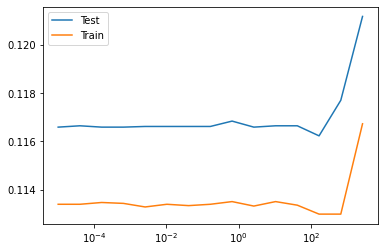

In [76]:
N = np.array(range(0,15))
lamb = 0.00001*(4**N)
error_trn = np.zeros(15)
error_tst = np.zeros(15)
for i in N:
    c = lamb[i]
    clf = LogisticRegression( C = 1/c, solver = 'sag', max_iter= 5000)
    clf.fit(X_trn_gnb, y_trn_gnb)
    y_pred = clf.predict(X_tst_gnb)
    error_tst[i] = hamming_loss(y_tst_gnb, y_pred)
    y_pred_trn = clf.predict(X_trn_gnb)
    error_trn[i] = hamming_loss(y_trn_gnb, y_pred_trn)
plt.figure(1)
plt.semilogx(lamb, error_tst, label = 'Test')
plt.semilogx(lamb, error_trn, label = 'Train')
plt.legend()

## Decision Tree

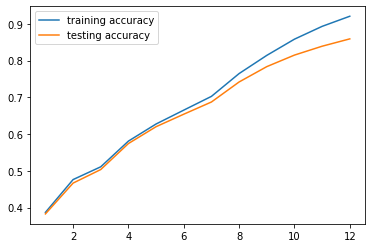

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
Acc_Train = np.zeros(12)
Acc_Test = np.zeros(12)
indices = range(1,13)
for i in indices:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = i)
    clf.fit(X_trn_gnb, y_trn_gnb)
    train_pred = clf.predict(X_trn_gnb)
    test_pred = clf.predict(X_tst_gnb)
    Acc_Train[i-1] = accuracy_score(train_pred, y_trn_gnb) 
    Acc_Test[i-1] = accuracy_score(test_pred, y_tst_gnb)   
#==============================================
plt.plot(indices,Acc_Train, label = "training accuracy")
plt.plot(indices,Acc_Test, label = "testing accuracy")
plt.legend()

## Support Vector Machine(SVM)

In [31]:
from sklearn.svm import SVC
# n = np.array(range(10))
# C = 2**n
accuracy_tst = []
accuracy_trn = []
#========Your Code Here============
for i in range(1,10):
    clf_trn = SVC(C=i, kernel='linear')
    clf_trn.fit(X_trn_gnb, y_trn_gnb)
    accuracy_trn.append(clf_trn.score(X_trn_gnb, y_trn_gnb))
    accuracy_tst.append(clf_trn.score(X_tst_gnb, y_tst_gnb))
max_acc = np.max(accuracy_tst)
#=============================
plt.semilogx(C, accuracy_tst)
plt.semilogx(C, accuracy_trn)
plt.title("Linear SVM")
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()
print('The maximum testing accuracy achieved with Linear SVM is: ' + str(max_acc))

NameError: name 'C' is not defined

In [34]:
print('The maximum testing accuracy achieved with Linear SVM is: ' + str(max_acc))

The maximum testing accuracy achieved with Linear SVM is: 0.9301944444444444
